In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pygame

pygame 2.1.2 (SDL 2.0.18, Python 3.8.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [15]:
# 求直线方向向量[m,n,p]

def Direction_vector(x1, y1, z1, x2, y2, z2):
    m = x1 - x2
    n = y1 - y2
    p = z1 - z2
    print('m', m)
    print('n', n)
    print('p', p)
    return m, n, p

# 三点法平面方程求解


def Find_plane_equation(xo1, yo1, zo1, xo2, yo2, zo2, xo3, yo3, zo3):
    a = (yo2 - yo1) * (zo3 - zo1) - (zo2 - zo1) * (yo3 - yo1)
    b = (xo3 - xo1) * (zo2 - zo1) - (xo2 - xo1) * (zo3 - zo1)
    c = (xo2 - xo1) * (yo3 - yo1) - (xo3 - xo1) * (yo2 - yo1)
    d = -(a * xo1 + b * yo1 + c * zo1)
    Equation_parameters = np.array([a, b, c, d])
    print('Plane equation parameters', Equation_parameters)

    return Equation_parameters

# 求解直线与平面的交点


def Find_intersection(p1, p2, equation_parameter):
    m = p1[0] - p2[0]
    n = p1[1] - p2[1]
    p = p1[2] - p2[2]
    t = (-equation_parameter[0] * p1[0] - equation_parameter[1] * p1[1] - equation_parameter[2] * p1[2] - equation_parameter[3]) / (equation_parameter[0] * m + equation_parameter[1] * n + equation_parameter[2] * p)

    x = m * t + p1[0]
    y = n * t + p1[1]
    z = p * t + p1[2]
    X = np.array([x, y, z])

    return X

def LineLine_dist(point_a,vector_a,point_b,vector_b):
    vector_a = (vector_a)/np.linalg.norm(vector_a)
    vector_b = (vector_b)/np.linalg.norm(vector_b)
    dist = abs(np.cross(vector_a,vector_b).dot(point_a-point_b))
    
    return dist




In [16]:
point_a  = np.array([0,0,0])
point_b  = np.array([1,1,0])
point_c  = np.array([1,0,1])
point_d  = np.array([0,1,1])
vector_a = point_a - point_b
vector_b = point_c - point_d


dist  = LineLine_dist(point_a,vector_a,point_c,vector_b)
print(dist)


0.9999999999999998


In [4]:
'''ROBOT MODEL'''
class robot_arm_2dof:
    def __init__(self, l):
        self.l = l  # link length
        self.q = np.zeros([2])  # joint position
        self.q2 = np.zeros([2])  # joint position

    # forward kinematics
    def FK(self, q):
        p = np.zeros([2])  # endpoint position
        p[0] = self.l[0] * math.cos(self.q[0]) + self.l[1] * math.cos(self.q[1] + self.q[0])
        p[1] = self.l[0] * math.sin(self.q[0]) + self.l[1] * math.sin(self.q[1] + self.q[0])
        return p

    def FK_DH(self, q):
        p = np.zeros([2])  # endpoint position
        # DH parameter
        alpha = np.zeros([2])
        a = np.zeros([2])
        a[0] = self.l[0]
        a[1] = self.l[1]
        d = np.zeros([2])
        theta = np.zeros([2])
        theta[0] = self.q[0]
        theta[1] = self.q[1]
        T = []
        A = np.identity(4)
        for i in range(2):
            T_zd = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d[i]], [0, 0, 0, 1]])
            T_ztheta = np.array(
                [[np.cos(theta[i]), -np.sin(theta[i]), 0, 0], [np.sin(theta[i]), np.cos(theta[i]), 0, 0], [0, 0, 1, 0],
                 [0, 0, 0, 1]])
            T_xa = np.array([[1, 0, 0, a[i]], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
            T_xalpha = np.array(
                [[1, 0, 0, 0], [0, np.cos(alpha[i]), -np.sin(alpha[i]), 0], [0, np.sin(alpha[i]), np.cos(alpha[i]), 0],
                 [0, 0, 0, 1]])
            A = A.dot(T_zd.dot(T_ztheta.dot(T_xa).dot(T_xalpha)))
       
        p = A.dot(np.array([0, 0, 0, 1]))
        return p[0:2]

    # Jacobian matrix
    def Jacobian(self):
        J = np.zeros([2, 2])
        J[0, 0] = self.l[0] * (-math.sin(self.q[0]) - self.l[1] * math.sin(self.q[0] + self.q[1]))
        J[0, 1] = self.l[1] * (-math.sin(self.q[1] + self.q[0]))
        J[1, 0] = self.l[0] * math.cos(self.q[0]) + l[1] * math.cos(self.q[0] + self.q[1])
        J[1, 1] = self.l[1] * (math.cos(self.q[0] + self.q[1]))

        return J

    # inverse kinematics
    def IK_Analytical(self, p):
        q = np.zeros([2])
        r = np.sqrt(p[0] ** 2 + p[1] ** 2)
        q[1] = np.pi - math.acos((self.l[0] ** 2 + self.l[1] ** 2 - r ** 2) / (2 * self.l[0] * self.l[1]))
        q[0] = math.atan2(p[1], p[0]) - math.acos((self.l[0] ** 2 - self.l[1] ** 2 + r ** 2) / (2 * self.l[0] * r))

        return q

    # inverse kinematics
    def IK_Numerical(self, p):
        q_sim = []
        error = p - self.FK(self.q)
        while abs(np.linalg.norm(error)) > 0.0001:
            J = self.Jacobian()
            # print(np.linalg.inv(J))
            self.q = self.q + np.linalg.inv(J).dot(error)
            error = p - self.FK(self.q)
            q_sim.append(self.q)
        return self.q, q_sim

    
    
    def residual_error(self,):
        
        
        
        
        return error
    
    # state change
    def Init_state(self, q):
        self.q = q

In [5]:
def sim_in_2D(self):
    fig = plt.figure(figsize=(20,20))
    p0 = [0,0]
    p1 = p[0][:2]*1000 #点p1的坐标值
    p2 = p[1][:2]*1000 #点p2的坐标值
    p3 = p[2][:2]*1000 #点p2的坐标值
    p4 = p[3][:2]*1000 #点p2的坐标值
    p5 = p[4][:2]*1000 #点p2的坐标值
    plt.subplot(3,1,1)
    plt.title('XY')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-1*1000,0.5*1000) 
    plt.ylim(-1*1000,0.5*1000)
    plt.plot((p0[0],p1[0],p2[0],p3[0],p4[0],p5[0]), (p0[1],p1[1],p2[1],p3[1],p4[1],p5[1]))

    plt.grid(visible=True)
    plt.text(p1[0], p1[1], (p1[0], p1[1]))
    plt.text(p4[0], p4[1], (p4[0], p4[1]))
    ax = plt.gca()
    ax.set_aspect(1)
    plt.scatter((p3[0],p4[0]),(p3[1],p4[1]),color='black')
    plt.scatter((p1[0],p2[0]),(p1[1],p2[1]),color='red')
    plt.scatter((p1[0]),(p1[1]),color='yellow')
    plt.scatter((p0[0],p0[0]),(p0[1],p0[1]),color='pink')
    plt.subplot(3,1,2)
    plt.title('YZ')
    plt.xlabel('y')
    plt.ylabel('z')
    p0 = [0,0]
    p1 = p[0][1:]*1000 #点p1的坐标值
    p2 = p[1][1:]*1000 #点p2的坐标值
    p3 = p[2][1:]*1000 #点p3的坐标值
    p4 = p[3][1:]*1000 #点p4的坐标值
    p5 = p[4][1:]*1000 #点p5的坐标值
    plt.xlim(-1*1000,0.5*1000) 
    plt.ylim(-1*1000,0.5*1000)
    plt.plot((p0[0],p1[0],p2[0],p3[0],p4[0],p5[0]), (p0[1],p1[1],p2[1],p3[1],p4[1],p5[1]))
    plt.grid(visible=True)
    plt.text(p1[0], p1[1], (p1[0], p1[1]))
    plt.text(p4[0], p4[1], (p4[0], p4[1]))
    ax = plt.gca()
    ax.set_aspect(1)
    plt.scatter((p3[0],p4[0]),(p3[1],p4[1]),color='black')
    plt.scatter((p1[0],p2[0]),(p1[1],p2[1]),color='red')
    plt.scatter((p1[0]),(p1[1]),color='yellow')
    plt.scatter((p0[0],p0[0]),(p0[1],p0[1]),color='pink')
    plt.subplot(3,1,3)
    plt.title('XZ')
    plt.xlabel('x')
    plt.ylabel('z')
    p0 = [0,0]
    p1 = p[0][[0,2]]*1000 #点p1的坐标值
    p2 = p[1][[0,2]]*1000 #点p2的坐标值
    p3 = p[2][[0,2]]*1000 #点p3的坐标值
    p4 = p[3][[0,2]]*1000 #点p4的坐标值
    p5 = p[4][[0,2]]*1000 #点p5的坐标值
    plt.xlim(-1*1000,0.5*1000) 
    plt.ylim(-1*1000,0.5*1000)
    plt.plot((p0[0],p1[0],p2[0],p3[0],p4[0],p5[0]), (p0[1],p1[1],p2[1],p3[1],p4[1],p5[1]))

    plt.grid(visible=True)
    plt.text(p1[0], p1[1], (p1[0], p1[1]))
    plt.text(p4[0], p4[1], (p4[0], p4[1]))
    ax = plt.gca()
    ax.set_aspect(1)
    plt.scatter((p3[0],p4[0]),(p3[1],p4[1]),color='black')
    plt.scatter((p1[0],p2[0]),(p1[1],p2[1]),color='red')
    plt.scatter((p1[0]),(p1[1]),color='yellow')
    plt.scatter((p0[0],p0[0]),(p0[1],p0[1]),color='pink')
    plt.show()

In [6]:
class robotarm_3RP:
    def __init__(self):
        self.q = np.zeros(4)  # joint position
        self.plane_parameter = [-0,     0,     1,    -0.032]
    def FK_SDH(self):
        theta = [np.pi/2 + self.q[0], 0, -np.pi/2+ self.q[2],  self.q[3]+np.pi/2,0]
        d = [0.032, 0.0528+self.q[1] , 0.256, 0,0.2]
        a =  [0, 0, -0.03, -0.04,0]
        alpha = [-np.pi/2, 0, -np.pi/2, np.pi/2,0]
        A = np.identity(4)
        p = []
        T = []
        for i in range(5):
            T_zd = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, d[i]], [0, 0, 0, 1]])
            T_ztheta = np.array(
                [[np.cos(theta[i]), -np.sin(theta[i]), 0, 0], 
                 [np.sin(theta[i]), np.cos(theta[i]), 0, 0], 
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])
            T_xa = np.array([[1, 0, 0, a[i]], 
                             [0, 1, 0, 0], 
                             [0, 0, 1, 0], 
                             [0, 0, 0, 1]])
            T_xalpha = np.array(
                [[1, 0, 0, 0], 
                 [0, np.cos(alpha[i]), -np.sin(alpha[i]), 0], 
                 [0, np.sin(alpha[i]), np.cos(alpha[i]), 0],
                 [0, 0, 0, 1]])
            
            A = A.dot(T_zd.dot(T_ztheta.dot(T_xa).dot(T_xalpha)))
            temp = A.dot(np.array([0, 0, 0, 1]))
            p.append(np.around(temp,10))
            T.append(A)
        return p, T
    
        
    def IK_analytical(self,inter_point):
        self.q[0] = math.atan2(inter_point[1],inter_point[0])+np.pi
        self.q[2] = math.atan2(inter_point[4],inter_point[5])
        self.q[3] = math.atan2(inter_point[3],inter_point[5])
        p_current,T = self.FK_SDH()
        p1_current = p_current[-2:][0][0:3]
        p2_current = p_current[-2:][1][0:3]
        inter_point_current = Find_intersection(p1_current,p2_current,self.plane_parameter)
        self.q[1] = -np.sqrt((inter_point_current[0])**2 + (inter_point_current[1])**2)+np.sqrt((inter_point[0])**2 + (inter_point[1])**2)
        return self.q
    
    def IK_numerical(self):
        
        
        
        
        
        
        
        
        
        
        
        
        return
    def rotation_matrix(self,T):
        R = []
        for i in range(len(T)):
            R.append(T[i][0:3,0:3])
        return R
        
    def space_jacobian(self):
        space_jacobian = np.zeros([6,4])
        p,T = self.FK_SDH()
        R = self.rotation_matrix(T)
        z0 = np.array([0,0,1])
        p0 = np.array([0,0,0,1])
        z = []
        pe = []
        z.append(z0)
        pe.append(p0)
        for i in range(4):
            z.append(R[i].dot(z0))
            pe.append((T[i].dot(p0)))
        for i in range(4):
            if i != 1:
                space_jacobian[:3,i] = np.cross(z[i],((pe[-1]-pe[i])[0:3]))
                space_jacobian[3:,i] = z[i]
            else:
                space_jacobian[:3,i] = z[i]
        
        return space_jacobian
    
    def body_jacobian(self):
        space_j = self.space_jacobian()
        p,T = self.FK_SDH()
        T04 = T[-1]
        inv_T = np.linalg.inv(T04)
        body_j = np.zeros([6,6])
        body_j[:3,:3] = inv_T[:3,:3]
        body_j[3:6,3:6] = inv_T[:3,:3]
        return body_j

[-0.5    0.3    0.032]


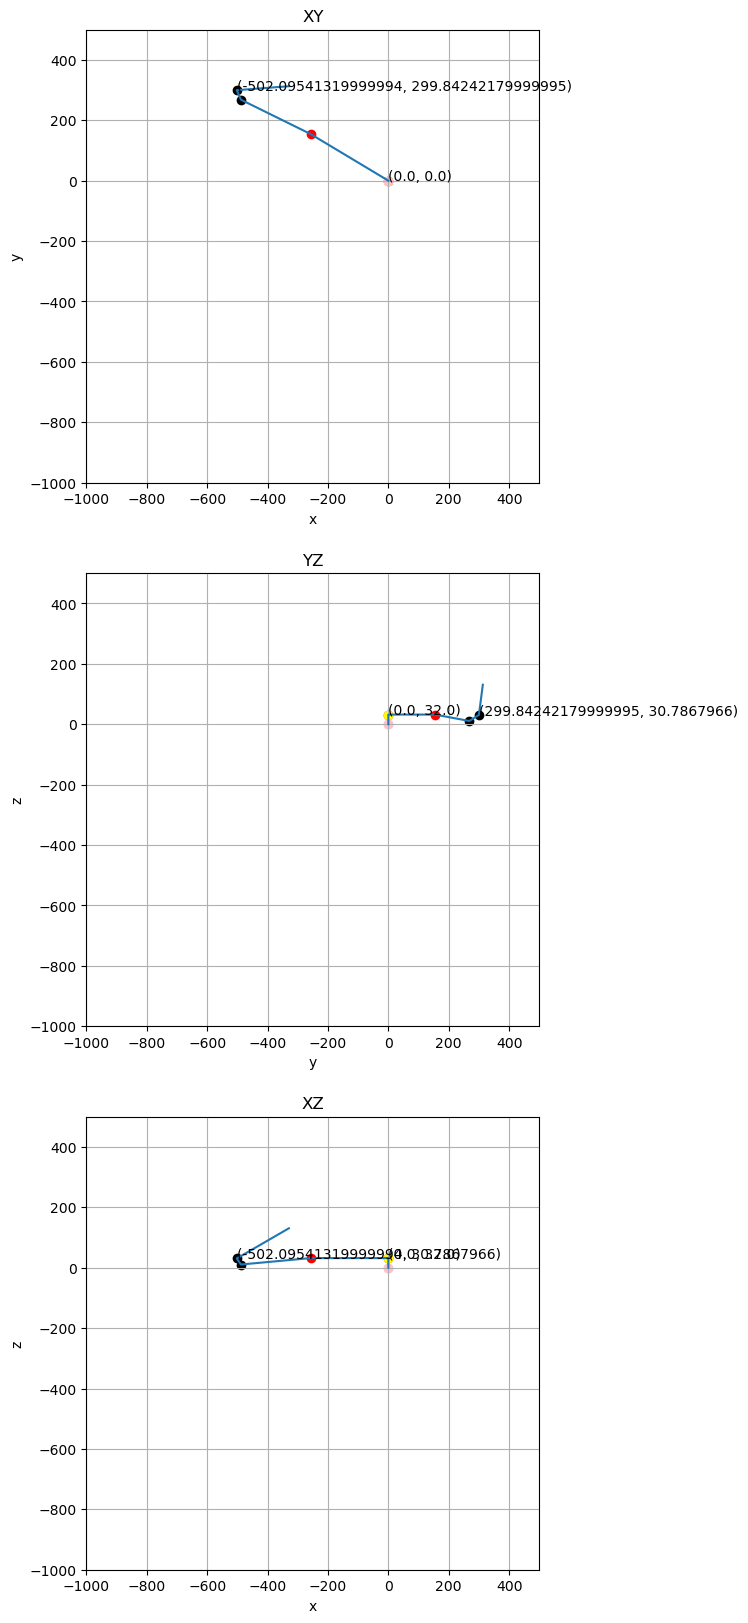

In [7]:
# SIMULATOR
# initialise robot model class
q = np.array([0,0,0,0])
model = robotarm_3RP()
inter_point = [-0.5,0.3,0.032,1,1,1]
q = model.IK_analytical(inter_point)
space_j = model.space_jacobian()
body_j = model.body_jacobian()
p,T2 = model.FK_SDH()
model.rotation_matrix(T2)
print(Find_intersection(p[-2][0:3],p[-1][0:3],model.plane_parameter))
sim_in_2D(p)

In [8]:
'''SIMULATION'''
# SIMULATION PARAMETERS
dt = 1  # intergration step timedt = 0.01 # integration step time
dts = dt * 1  # desired simulation step time (NOTE: it may not be achieved)

# ROBOT PARAMETERS
x0 = 0.0  # base x position
y0 = 0.0  # base y position
l1 = 0.3  # link 1 length
l2 = 0.3  # link 2 length
l = [l1, l2]  # link length

# REFERENCE TRAJETORY
ts = dt  # trajectory size
x = 1
y = 1

# SIMULATOR
# initialise robot model class
model = robot_arm_2dof(l)

q_init = [-np.pi, np.pi/2]
model.Init_state(q_init)
p_ref = [0.0, 0.6]  # reference endpoint trajectory
q_IK_numerical, q_sim = model.IK_Numerical(p_ref)
print("iteration for", len(q_sim))
q_IK_analytical = model.IK_Analytical(p_ref)
pr_numerical = model.FK(q_IK_numerical)

iteration for 28


In [9]:
# initialise real-time plot with pygame
def run_game(q_sim):
    pygame.init()  # start pygame
    window = pygame.display.set_mode((800, 600))  # create a window (size in pixels)
    window.fill((255, 255, 255))  # white background
    xc, yc = window.get_rect().center  # window center
    pygame.display.set_caption('robot arm')

    font = pygame.font.Font('freesansbold.ttf', 12)  # printing text font and font size
    text = font.render('robot arm', True, (0, 0, 0), (255, 255, 255))  # printing text object
    textRect = text.get_rect()
    textRect.topleft = (10, 10)  # printing text position with respect to the top-left corner of the window

    clock = pygame.time.Clock()  # initialise clock
    FPS = int(1 / dts)  # refresh rate

    # initial conditions
    state = []  # state vector

    # scaling
    window_scale = 400  # conversion from meters to pixles
# wait until the start button is pressed
    run = True
    while run:
        for event in pygame.event.get():  # interrupt function
            if event.type == pygame.KEYUP:
                if event.key == ord('e'):  # enter the main loop after 'e' is pressed
                    run = False
    # wait until the start button is pressed
    run = True
    while run:
    # MAIN LOOP
        for i in range(len(q_sim)):
            for event in pygame.event.get():  # interrupt function
                if event.type == pygame.QUIT:  # force quit with closing the window
                    run = False
                elif event.type == pygame.KEYUP:
                    if event.key == ord('q'):  # force quit with q button
                        run = False
            # update individual link position    
            x1 = l1 * np.cos(q_sim[i][0])
            y1 = l1 * np.sin(q_sim[i][0])
            x2 = x1 + l2 * np.cos(q_sim[i][0] + q_sim[i][1])
            y2 = y1 + l2 * np.sin(q_sim[i][0] + q_sim[i][1])
          # real-time plotting
            window.fill((255, 255, 255))  # clear window
            pygame.draw.circle(window, (0, 255, 0), (int(window_scale * p_ref[0]) + xc, int(-window_scale * p_ref[1]) + yc),
                       10)  # draw reference position

            pygame.draw.lines(window, (0, 0, 255), False, [(window_scale * x0 + xc, -window_scale * y0 + yc),
                                                   (window_scale * x1 + xc, -window_scale * y1 + yc),
                                                   (window_scale * x2 + xc, -window_scale * y2 + yc)], 3)  # draw
            # links
            pygame.draw.circle(window, (0, 0, 0), (int(window_scale * x0) + xc, int(-window_scale * y0) + yc),
                       7)  # draw shoulder / base
            pygame.draw.circle(window, (0, 0, 0), (int(window_scale * x1) + xc, int(-window_scale * y1) + yc),
                       7)  # draw elbow
            pygame.draw.circle(window, (255, 0, 0), (int(window_scale * x2) + xc, int(-window_scale * y2) + yc),
                       5)  # draw hand / endpoint
            text = font.render("FPS = " + str(round(clock.get_fps())), True, (0, 0, 0), (255, 255, 255))
            window.blit(text, textRect)
            pygame.display.flip()  # update display
            clock.tick(FPS)  # try to keep it real time with the desired step time 
            if run==False:
                break
    pygame.quit()

In [10]:
run_game(q_sim)